In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
import ast
import pickle

The original essential genes dataset had 28166 rows but only 26791 had available sequences.

In [2]:
deg_dataset = pd.read_csv("datasets/essential_genes.csv", sep=';')
print(deg_dataset.shape)

eg_negative = pd.read_csv("datasets/essential_genes_negative.csv", sep=',')
print(eg_negative.shape)

(26791, 15)
(27684, 2)


Creating positive essential genes dataset. Each sequence needs to be in at least 5 datasets.

In [3]:
# for each sequence, get all the datasets that contain it
d = {}
for _, row in deg_dataset.iterrows():
    if(row["sequence"] in d):
        d[row["sequence"]].append((row["id1"], row["id4"]))
    else:
        d[row["sequence"]] = [(row["id1"], row["id4"])]


# get a list of sequences that are in more than 5 datasets
essential_sequences = []
for key, val in d.items():
    if(len(val) >= 5):
        essential_sequences.append((val[0][1], key))
        
# create dataframe with essential sequences
eg_positive = pd.DataFrame(essential_sequences, columns=["id", "sequence"])
print(eg_positive.head())
print(eg_positive.shape)

# write to csv
eg_positive.to_csv("datasets/essential_genes_positive.csv", index=False)

     id                                           sequence
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...
(2010, 2)


At this point, we have both positive and negative datasets:
* eg_positive -> positive dataset with essential genes (genes contained in at least 5 datasets) (2010, 2)
* eg_negative -> negative dataset with non essential genes (if sequences from the DEG dataset were on the Ensembl dataset, they were removed. Also, each sequence in DEG dataset had an EMBL id associated and, even if the sequence itself was not the same with the sequence with that ID in the EMBL dataset, they also go removed, forming the negative dataset) (27684, 2)

In [4]:
print("unique positive sequences:", len(set(eg_positive["sequence"])))
print("unique negative sequences:", len(set(eg_negative["sequence"])))

unique positive sequences: 2010
unique negative sequences: 23443


Even though the negative dataset has 27684 sequences, not all of them are unique. So, we need to remove the duplicates.

In [5]:
eg_negative = eg_negative.drop_duplicates(subset="sequence")
print(eg_negative.shape)

(23443, 2)


Calculating length of each sequence and cleaning up the data

In [6]:
eg_positive["length"] = eg_positive["sequence"].str.len()
eg_negative["length"] = eg_negative["sequence"].str.len()

In [7]:
print("before removing")
print(eg_positive.shape)
print(eg_negative.shape)

old_eg_positive = eg_positive.shape[0]
old_eg_negative = eg_negative.shape[0]

eg_positive = eg_positive[eg_positive["length"] <= 20000]
eg_negative = eg_negative[eg_negative["length"] <= 20000]
print("after removing")
print(eg_positive.shape, old_eg_positive - eg_positive.shape[0], "were removed")
print(eg_negative.shape, old_eg_negative - eg_negative.shape[0], "were removed")

before removing
(2010, 3)
(23443, 3)
after removing
(2010, 3) 0 were removed
(23439, 3) 4 were removed


Statistics about the data, including:
* Total sequences
* Top 5 longest and shortest sequences
* Average length of sequences
* Top 5 most and least common sequence length

In [8]:
def stats(dataset):
    dataset["length"].hist(bins=100)
    plt.show()

    print("-" * 40)

    print("Total sequences:", dataset.shape[0])

    print("-" * 40)

    print("Top 5 longest sequences:")
    print("id       length")
    print(dataset["length"].nlargest(5).to_string())

    print("-" * 40)

    print("Top 5 shortest sequences:")
    print("id       length")
    print(dataset["length"].nsmallest(5).to_string())

    print("-" * 40)

    average_length = dataset["length"].mean()
    print("Average length:", average_length)

    print("-" * 40)

    print("Top 5 most common lengths:")
    print("length   count")
    print(dataset["length"].value_counts().nlargest(5).to_string())
    
    print("-" * 40)

    print("Top 5 least common lengths:")
    print("length   count")
    print(dataset["length"].value_counts().nsmallest(5).to_string())

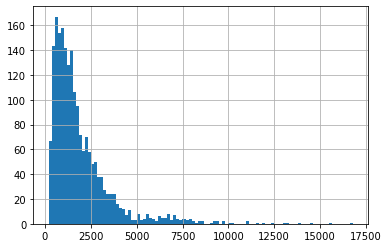

----------------------------------------
Total sequences: 2010
----------------------------------------
Top 5 longest sequences:
id       length
676    16791
248    15615
204    14574
491    13941
31     13167
----------------------------------------
Top 5 shortest sequences:
id       length
1112    192
1427    195
1500    204
1611    204
1346    210
----------------------------------------
Average length: 1903.6034825870647
----------------------------------------
Top 5 most common lengths:
length   count
1083    9
1041    8
618     7
585     7
1314    7
----------------------------------------
Top 5 least common lengths:
length   count
4311    1
2289    1
2958    1
513     1
2799    1
****************************************************************************************************


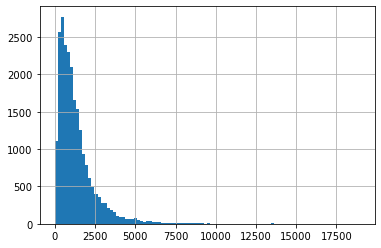

----------------------------------------
Total sequences: 23439
----------------------------------------
Top 5 longest sequences:
id       length
20105    18921
2852     17673
12774    17388
23013    17289
25523    16965
----------------------------------------
Top 5 shortest sequences:
id       length
6728      3
14762     5
13586    10
23228    10
25635    12
----------------------------------------
Average length: 1351.6297196979394
----------------------------------------
Top 5 most common lengths:
length   count
939    98
945    76
930    72
444    66
948    63
----------------------------------------
Top 5 least common lengths:
length   count
644      1
997      1
11724    1
607      1
10896    1


In [9]:
stats(eg_positive)
print("*" * 100)
stats(eg_negative)

Joining the positive and negative datasets

In [10]:
# adding labels to the dataset
eg_positive["label"] = 1
eg_negative["label"] = 0

# removing length column
eg_positive = eg_positive.drop(columns=["length"])
eg_negative = eg_negative.drop(columns=["length"])

# joining the two datasets
dataset = pd.concat([eg_positive, eg_negative])
print(dataset.shape)
print(dataset.head())

(25449, 3)
     id                                           sequence  label
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...      1
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...      1
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...      1
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...      1
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...      1


## Classification using DNA descriptors

In [11]:
%load_ext autoreload
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

sys.path.append('../../../../src/')
from propythia.shallow_ml import ShallowML
from propythia.DNA.descriptors.descriptors import DNADescriptor

In [12]:
print(dataset.shape)

(25449, 3)


<AxesSubplot:xlabel='label'>

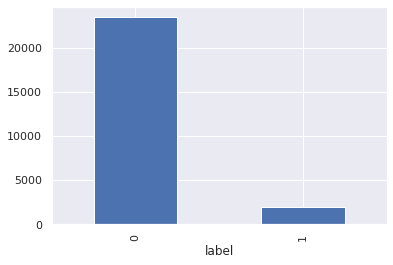

In [13]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

In [14]:
# List of descriptors to be calculed. If empty, all descriptors will be calculated.
specifics = []

def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        feature = dna.get_descriptors(specifics=specifics)
        res.update(feature)
        list_feature.append(res)
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df


# ----------------------------------- Using pickle -----------------------------------
if exists("datasets/essential_genes_features.pkl"):
    with open("datasets/essential_genes_features.pkl", "rb") as f:
        features = pickle.load(f)
else:
    features = calculate_feature(dataset)
    with open("datasets/essential_genes_features.pkl", "wb") as f:
        pickle.dump(features, f)

0 / 25449
100 / 25449
200 / 25449
300 / 25449
400 / 25449
500 / 25449
600 / 25449
700 / 25449
800 / 25449
900 / 25449
1000 / 25449
1100 / 25449
1200 / 25449
1300 / 25449
1400 / 25449
1500 / 25449
1600 / 25449
1700 / 25449
1800 / 25449
1900 / 25449
2000 / 25449
2100 / 25449
2200 / 25449
2300 / 25449
2400 / 25449
2500 / 25449
2600 / 25449
2700 / 25449
2800 / 25449
2900 / 25449
3000 / 25449
3100 / 25449
3200 / 25449
3300 / 25449
3400 / 25449
3500 / 25449
3600 / 25449
3700 / 25449
3800 / 25449
3900 / 25449
4000 / 25449
4100 / 25449
4200 / 25449
4300 / 25449
4400 / 25449
4500 / 25449
4600 / 25449
4700 / 25449
4800 / 25449
4900 / 25449
5000 / 25449
5100 / 25449
5200 / 25449
5300 / 25449
5400 / 25449
5500 / 25449
5600 / 25449
5700 / 25449
5800 / 25449
5900 / 25449
6000 / 25449
6100 / 25449
6200 / 25449
6300 / 25449
6400 / 25449
6500 / 25449
6600 / 25449
6700 / 25449
6800 / 25449
6900 / 25449
7000 / 25449
7100 / 25449
7200 / 25449
7300 / 25449
7400 / 25449
7500 / 25449
7600 / 25449
7700 / 2544

In [15]:
fps_y = dataset['label']
fps_x = features.loc[:, features.columns != 'label']
fps_x = fps_x.loc[:, fps_x.columns != 'sequence']
fps_x.shape

(25449, 20)

In [16]:
def process_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    fps_x.drop(field, axis=1, inplace=True)
    return new_df

def process_lists_of_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    empty_val = {} if field == "enhanced_nucleic_acid_composition" else []
    small_processed = []
    count = 0
    for f in new_df.columns:
        col = [empty_val if i is None else i for i in new_df[f].to_list()]
        sub = pd.DataFrame(col)
        sub.columns = [str(f) + "_" + str(i) for i in sub.columns]
        small_processed.append(sub)
        if(count % 1000 == 0):
            print(count, '/', len(new_df.columns))
        count += 1
    fps_x.drop(field, axis=1, inplace=True)
    return small_processed

In [17]:
no_need_normalization = ["length", "at_content", "gc_content"]
lists = ["nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC", "DAC", "DCC", "DACC", "TAC","TCC","TACC", "accumulated_nucleotide_frequency"]
lists_of_lists = [
    "enhanced_nucleic_acid_composition",
    "nucleotide_chemical_property", 
    "binary"
]

small_processed = []
for i in lists:
    print("Starting:", i)
    new_df = process_lists(fps_x, i)
    small_processed.append(new_df)
    
for i in lists_of_lists:
    print("Starting:", i)
    smaller_processed = process_lists_of_lists(fps_x, i)
    small_processed += smaller_processed

# concat final with original
fps_x = pd.concat([fps_x, *small_processed], axis=1)


with open("datasets/fps_x.pkl", "wb") as f:
    pickle.dump(fps_x, f)
    
with open("datasets/fps_y.pkl", "wb") as f:
    pickle.dump(fps_y, f)
fps_x

Starting: nucleic_acid_composition
Starting: dinucleotide_composition
Starting: trinucleotide_composition
Starting: k_spaced_nucleic_acid_pairs
Starting: kmer
Starting: PseDNC
Starting: PseKNC
Starting: DAC
Starting: DCC
Starting: DACC
Starting: TAC
Starting: TCC
Starting: TACC
Starting: accumulated_nucleotide_frequency
Starting: enhanced_nucleic_acid_composition
0 / 18917
1000 / 18917
2000 / 18917
3000 / 18917
4000 / 18917
5000 / 18917
6000 / 18917
7000 / 18917
8000 / 18917
9000 / 18917
10000 / 18917
11000 / 18917
12000 / 18917
13000 / 18917
14000 / 18917
15000 / 18917
16000 / 18917
17000 / 18917
18000 / 18917
Starting: nucleotide_chemical_property
0 / 18921
1000 / 18921
2000 / 18921
3000 / 18921
4000 / 18921
5000 / 18921
6000 / 18921
7000 / 18921
8000 / 18921
9000 / 18921
10000 / 18921
11000 / 18921
12000 / 18921
13000 / 18921
14000 / 18921
15000 / 18921
16000 / 18921
17000 / 18921
18000 / 18921
Starting: binary
0 / 18921
1000 / 18921
2000 / 18921
3000 / 18921
4000 / 18921
5000 / 189

,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,dinucleotide_composition_AA,dinucleotide_composition_AC,dinucleotide_composition_AG,...,binary_18918_2,binary_18918_3,binary_18919_0,binary_18919_1,binary_18919_2,binary_18919_3,binary_18920_0,binary_18920_1,binary_18920_2,binary_18920_3
0,1233,0.440,0.560,0.303,0.193,0.247,0.256,0.096,0.052,0.075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8532,0.412,0.588,0.344,0.208,0.205,0.244,0.126,0.054,0.089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3720,0.604,0.396,0.215,0.290,0.314,0.181,0.041,0.050,0.089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1530,0.414,0.586,0.303,0.169,0.246,0.282,0.099,0.044,0.080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,963,0.559,0.441,0.212,0.286,0.273,0.229,0.048,0.045,0.076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25444,576,0.439,0.561,0.288,0.210,0.229,0.273,0.089,0.068,0.068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25445,576,0.434,0.566,0.286,0.212,0.222,0.280,0.089,0.068,0.066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25446,3363,0.394,0.606,0.338,0.192,0.202,0.268,0.122,0.055,0.076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25447,1101,0.633,0.367,0.227,0.292,0.341,0.140,0.037,0.056,0.105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Classification using Deep Learning and One hot encoding

In [18]:
# average_length = int(average_length)

# cut sequences to the average length
# seqs_dataset = seqs_dataset.str.slice(0, average_length)

# fill with "N" the sequences that are shorter than average length
# seqs_dataset = seqs_dataset.str.pad(average_length, side='right', fillchar='N')